# MA 544: Programming Assignment - 2
---


In [3]:
# Import required packages
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse import coo_matrix, csr_matrix
import gzip
import scipy.sparse as sp
import time
from sympy import primerange
import pandas as pd

### Question 1: Visualization of Sparse Matrices
---
Create the sparse COO representation of the adjacency matrix of the following graph. One need not find the 2-dimensional representation for doing so. Find its CSR representation using appropriate Python function. Visualize this matrix by using spy() function. Refer to the notebook on sparse Matrices and check [the SciPy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html#scipy.sparse.coo_matrix). 

<img src="https://in.mathworks.com/help/examples/matlab/win64/buckydem_02.png" width="50%" />

[Image source: Mathworks](https://in.mathworks.com/help/examples/matlab/win64/buckydem_02.png)

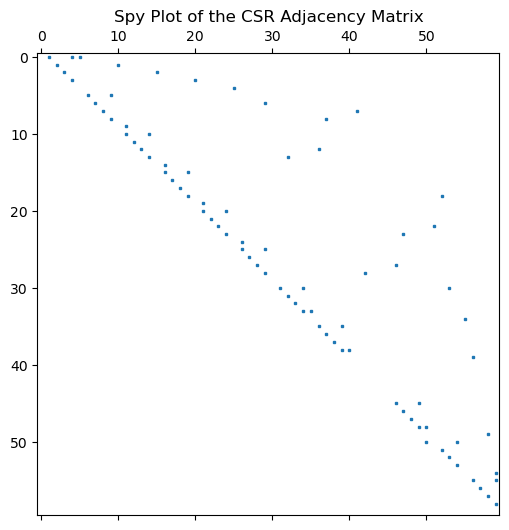

In [4]:
# Define the graph from the given image (assumed structure)
edges = [
    (1,2), (1,5), (1,6), (2,11), (2,3), (3,16), (3,4), (4,21), (4,5), (5,26), (6,7), (6,10),
    (7,8), (7,30), (8,9), (8,42), (9,10), (9,38), (10,12), (11,12), (11,15), (12,13), 
    (13,14), (13,37), (14,15), (14,33), (15,17), (16,20), (16,17), (17,18), (18,19), (19,20),
    (19,53), (20,22), (21,22), (21,25), (22,23), (23,24), (23,52), (24,25), (24,48), (25,27), 
    (26,27), (26,30), (27,28), (28,29), (28,47), (29,30), (29,43), (31,32), (31,35), (31,54),
    (32,33), (33,34), (34,35), (34,36), (35,56), (36,37), (36,40), (37,38), (38,39), (39,40),
    (39,41), (40,57), (46,47), (46,50), (47,48), (48,49), (49,50), (49, 51), (50,59), (51,51),
    (51,55), (52,53), (53,54), (54,55), (55,60), (56,57), (56,60), (57,58), (58,59), (59,60)
]
# Convert edges to zero-based index
edges = [(u-1, v-1) for u, v in edges]

# Create adjacency matrix in COO format
num_nodes = 60
row, col = zip(*edges)
data = np.ones(len(edges))

adj_coo = coo_matrix((data, (row, col)), shape=(num_nodes, num_nodes))

# Convert COO to CSR format
adj_csr = adj_coo.tocsr()

# Visualize the matrix using spy()
plt.figure(figsize=(6,6))
plt.spy(adj_csr, markersize=2)
plt.title("Spy Plot of the CSR Adjacency Matrix")
plt.show()


Question 2: Page Ranking
---
Visit the SNAP networks database to find the [Berkley-Stanford Webgraph from 2002](https://snap.stanford.edu/data/web-BerkStan.html). This dataset gives the hyperlink structure of $685230$ webpages having a total of $7600595$ hyperlinks. 

A. Download the datafile and read the data to create a link matrix $Q$ in the DoK format. 

B. Use the optimized page-ranking algorithm with damping factor values $\alpha=0.85$ and $\alpha=0.95$ to find the page-ranking vector $\mathbf{r}$ while maintaining the same tolerance level for convergence. Report on the time it takes to perform these calculations. 

C. Find the indices of the $10$ highest ranking web-pages in decreasing order for the two runs. 

D. Now use a personalization vector that gives equal non-zero probability to pages with prime indices otherwise zero. Find the indices of the $10$ highest ranking web-pages. Use  only $\alpha=0.85$ in this case.

In [7]:
import gzip
import numpy as np
import scipy.sparse as sp
import time
from sympy import primerange
import pandas as pd


# Step 1: Load web-BerkStan.txt.gz and Construct Adjacency Matrix
edge_list = []

with gzip.open("web-BerkStan.txt.gz", "rt", encoding="utf-8") as f:
    for line in f:
        if line.startswith("#"):  # Ignore comment lines
            continue
        src, dst = map(int, line.strip().split())  # Extract source and destination
        edge_list.append((src, dst))

# Convert to numpy array for easy processing
edge_list = np.array(edge_list)

# Get number of nodes dynamically (highest index in the dataset)
num_nodes = edge_list.max() + 1  # Assuming 0-based indexing

# Create adjacency matrix in DoK format
adj_matrix_dok = sp.dok_matrix((num_nodes, num_nodes), dtype=np.float32)
for src, dst in edge_list:
    adj_matrix_dok[src, dst] = 1  # Directed graph (hyperlinks)

# Convert to CSR format for fast computation
adj_matrix_csr = adj_matrix_dok.tocsr()

# Step 2: Compute PageRank using Power Iteration
def pagerank(adj_matrix, alpha=0.85, tol=1e-6, max_iter=100):
    n = adj_matrix.shape[0]
    
    # Convert adjacency matrix to stochastic matrix (column-normalized)
    out_degree = np.array(adj_matrix.sum(axis=0)).flatten()
    out_degree[out_degree == 0] = 1  # Avoid division by zero
    stochastic_matrix = adj_matrix.multiply(1 / out_degree).T
    
    # Initialize rank vector
    r = np.ones(n) / n  # Equal probability initially
    teleport = np.ones(n) / n  # Uniform teleportation
    
    # Power iteration
    start_time = time.time()
    for _ in range(max_iter):
        r_new = alpha * (stochastic_matrix @ r) + (1 - alpha) * teleport
        if np.linalg.norm(r_new - r, ord=1) < tol:
            break
        r = r_new
    elapsed_time = time.time() - start_time
    
    return r, elapsed_time

# Compute PageRank for alpha = 0.85
r_85, time_85 = pagerank(adj_matrix_csr, alpha=0.85)

# Compute PageRank for alpha = 0.95
r_95, time_95 = pagerank(adj_matrix_csr, alpha=0.95)

# Step 3: Find Top 10 Highest-Ranked Pages
top_10_85 = np.argsort(-r_85)[:10]  # Descending order
top_10_95 = np.argsort(-r_95)[:10]

# Step 4: Personalized PageRank with Prime Indices
prime_indices = list(primerange(1, num_nodes))  # Find prime indices
personalization_vector = np.zeros(num_nodes)
personalization_vector[prime_indices] = 1 / len(prime_indices)  # Equal probability for primes

def personalized_pagerank(adj_matrix, alpha=0.85, personalization=None, tol=1e-6, max_iter=100):
    n = adj_matrix.shape[0]
    out_degree = np.array(adj_matrix.sum(axis=0)).flatten()
    out_degree[out_degree == 0] = 1
    stochastic_matrix = adj_matrix.multiply(1 / out_degree).T
    
    # Initialize rank vector
    r = np.ones(n) / n
    teleport = personalization if personalization is not None else np.ones(n) / n

    # Power iteration
    for _ in range(max_iter):
        r_new = alpha * (stochastic_matrix @ r) + (1 - alpha) * teleport
        if np.linalg.norm(r_new - r, ord=1) < tol:
            break
        r = r_new
    
    return r

# Compute personalized PageRank
r_personalized = personalized_pagerank(adj_matrix_csr, alpha=0.85, personalization=personalization_vector)
top_10_personalized = np.argsort(-r_personalized)[:10]

# Display results
results = {
    "Top 10 Pages (α=0.85)": top_10_85,
    "Top 10 Pages (α=0.95)": top_10_95,
    "Top 10 Pages (Personalized, α=0.85)": top_10_personalized,
    "Time Taken (α=0.95)": time_95
}

df_results = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in results.items()]))
print(df_results)

   Top 10 Pages (α=0.85)  Top 10 Pages (α=0.95)  \
0                 630893                 630894   
1                 630891                 630900   
2                 585338                 630891   
3                 584351                 584351   
4                 585329                 585329   
5                 585330                 585330   
6                 585344                 585331   
7                 585331                 585332   
8                 630892                 585334   
9                 585332                 585335   

   Top 10 Pages (Personalized, α=0.85)  Time Taken (α=0.95)  
0                               559561             4.087448  
1                               395027                  NaN  
2                               559343                  NaN  
3                               395119                  NaN  
4                               130267                  NaN  
5                               489389                  NaN  
6   

### Question 3: Clustering
---
Pick up a dataset of your choice for clustering ([UCI dataset](https://archive.ics.uci.edu/datasets)). Apply various clustering algorithms (including at least k-means and spectral clustering) to this dataset and explain your observations by using insightful plots or other some other metrics. Compare these algorithms based on some metric such as silhouette score, adjusted rand index etc.

- Read [this blog](https://machinelearningmastery.com/clustering-algorithms-with-python/) for some help.
- You can also refer to the codes and discusion [for this Kaggle dataset](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python/data).